# Simulación numérica | Péndulo con punto de suspensión libre

[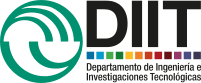](https://ingenieria.unlam.edu.ar/)  
2024 [Víctor A. Bettachini](mailto:vbettachini@unlam.edu.ar)  
[by-nc-sa_80x15.png](https://creativecommons.org/licenses/by-sa/4.0/deed.es_ES)

---

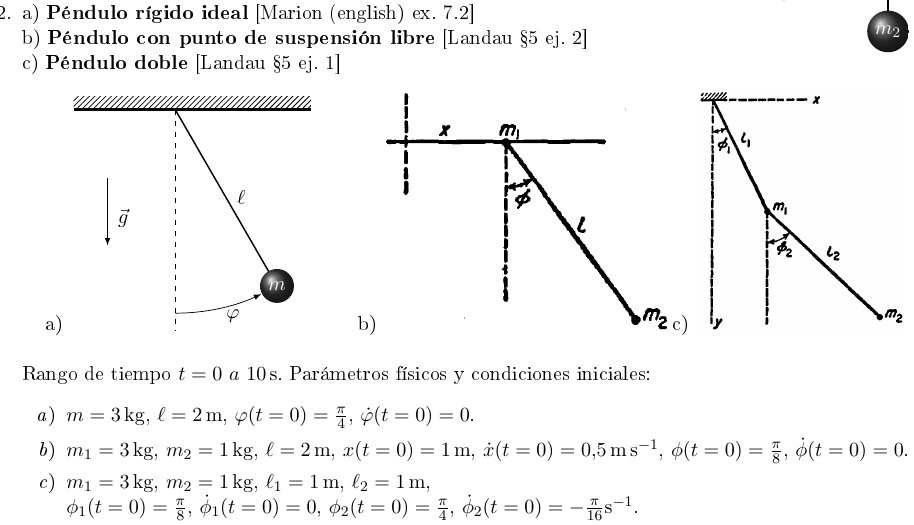

## Resolución simbólica

In [1]:
import sympy as sm # importamos funciones de cálculo simbólico
from sympy.physics import mechanics as me # de sympy utilizaremos funciones de mecánica
me.init_vprinting() # notación con punto para la velocidad y punto punto para la aceleración

### Modelo físico del sistema
- Dos coordenadas generalizadas: $x, \phi$
- Potencial externo: debido a la aceleración gravitatoria
- Ligaduras:
    - riel fuerza $\vec{r}_{m_1} = x \hat{x}$
    - cuerda de longitud $\ell$ impone  
$$|\vec{r}_{m_2} - \vec{r}_{m_1}| = \ell \implies \vec{r}_{m_2} = \vec{r}_{m_1} + \ell \hat{\rho}_2$$

#### Coordenadas generalizadas y ligaduras

In [2]:
# parámetros físicos del sistema
m1, m2, l, g = sm.symbols(r'm_1, m_2, \ell, g', positive=True)

# posiciones en función de coordenadas generalizadas
t = sm.symbols('t') # tiempo
x, phi = me.dynamicsymbols('x, phi')

#### Posiciones en función de coordenadas generalizadas

In [3]:
e = me.ReferenceFrame('e') # sistema de referencia en coordenadas cartesianas
m1_r = x* (e.x) # posición pesa 1: x = x(t)

Con la función de ligadura se describe la posición de $m_2$.

In [4]:
m2_r = m1_r + l* (sm.cos(phi)* (- e.y) +  sm.sin(phi)* (e.x) ) # posición pesa 2: definida por el vínculo
m1_r, m2_r

(x e_x, (\ell⋅sin(φ) + x) e_x + -\ell⋅cos(φ) e_y)

### Energías cinéticas de traslación

In [5]:
def energíaCinéticaTraslación(masa, posición, marcoDeReferencia):
    """
    A partir de la masa y posición de una partícula puntual en un marco de referencia devuelve su energía cinética.

    Parámetros
    ----------
    masa: (sympy.core.symbol.Symbol)
        De un partícula
    posición: (sympy.physics.vector.vector.Vector)
        del centro de masa de la partícula
    marcoDeReferencia: (sympy.physics.vector.frame.ReferenceFrame)
        En el que se expresa la posición

    Retorna
    -------
    Igualdad Sympy (sympy.core.relational.Equality)
        En su lado derecho explicita la energía cinética del sistema en función de coordenadas y velocidades generalizadas y el tiempo.
        Energía cinética, T = (m/2) \dot{\vec{r}} \cdot\dot{\vec{r}}
    """
    velocidad = posición.dt(marcoDeReferencia)
    unMedio = sm.Rational(1,2) # Rational: fracción de enteros, alternativamente podría haberse usado 0.5
    T_traslación = sm.Eq(
        sm.Symbol('T_{traslación}'),
        unMedio* masa* velocidad.dot(velocidad)
        ).simplify()
    return T_traslación

In [6]:
m1_T = energíaCinéticaTraslación(m1, m1_r, e)
m2_T = energíaCinéticaTraslación(m2, m2_r, e)
T = sm.Eq(
  m1_T.lhs,
  m1_T.rhs + m2_T.rhs
  ).simplify() # simplify: simplifica usando factor común y otras operaciones
T

                     2      ⎛    2  2                        2⎞
                 m₁⋅ẋ    m₂⋅⎝\ell ⋅φ̇  + 2⋅\ell⋅cos(φ)⋅φ̇⋅ẋ + ẋ ⎠
T_{traslación} = ───── + ──────────────────────────────────────
                   2                       2                   

### Energía potencial

In [7]:
def energíaPotencialGravitatoria(masa, posición, aceleracionGravitatoria):
    """
    Retorna la energía potencial gravitatoria de una partícula de masa m cuya posición r está dada en un sistema de referencia en el cual g es la aceleración gravitatoria terrestre.

    Parámetros
    ----------
    aceleracionGravitatoria: (sympy.physics.vector.vector.Vector)
        vector orientado según el sistema de referencia
    masa: (sympy.core.symbol.Symbol
        del cuerpo en cuestión
    posición: (sympy.core.symbol.Symbol)
        del centro de masa en un sistema de referencia relacionable con el de aceleracionGravitatoria

    Retorna
    -------
    Igualdad Sympy (sympy.core.relational.Equality)
        En su lado derecho explicita la energía potencial del sistema en función de coordenadas y velocidades generalizadas y el tiempo.
    coordenadaGeneralizada: Símbolo Sympy (sympy.core.symbol.Symbol)
        V = - (m \vec{aceleracionGravitatoria}) \cdot{posición}
    """
    V_gravitatoria = sm.Eq(
        sm.Symbol('V_{gravitatoria}'),
        - (masa* aceleracionGravitatoria).dot(posición)
        ).simplify()
    return V_gravitatoria

In [8]:
g_vector = g* (-e.y) # aceleración gravitatoria en -y versor
m1_V = energíaPotencialGravitatoria(m1, m1_r, g_vector)
m2_V = energíaPotencialGravitatoria(m2, m2_r, g_vector)

In [9]:
V = sm.Eq(
  m1_V.lhs,
  m1_V.rhs + m2_V.rhs
  ).simplify()
V

V_{gravitatoria} = -\ell⋅g⋅m₂⋅cos(φ)

### Ecuaciones de Euler-Lagrange

In [10]:
def eulerLagrange(T, V, coordenadaGeneralizada):
    '''
    Esta función devuelve la ecuación de Euler-Lagrange para una coordenada generalizada a partir de las energías del sistema.

    Parámetros
    ----------
    T : Igualdad Sympy (sympy.core.relational.Equality)
        En su lado derecho explicita la energía cinética del sistema en función de coordenadas y velocidades generalizadas y el tiempo.
    V : Igualdad Sympy (sympy.core.relational.Equality)
        En su lado derecho explicita la energía potencial del sistema en función de coordenadas y velocidades generalizadas y el tiempo.
    coordenadaGeneralizada: Símbolo Sympy (sympy.core.symbol.Symbol)
        Para la que quiere obtenerse la ecuación de Euler-Lagrange

    Retorna
    -------
    Igualdad Sympy (sympy.core.relational.Equality)
        Ecuación de Euler-Lagrange homogénea para la coordenadaGeneralizada
    '''
    lagrangiano = (T.rhs - V.rhs).expand()
    t = sm.Symbol('t') # como se deriva respecto al tiempo con la función diff se declara t como símbolo
    return sm.Eq(
        lagrangiano.diff(coordenadaGeneralizada.diff(t)).diff(t)
        - lagrangiano.diff(coordenadaGeneralizada)
        , 0
    ).simplify()

#### Para $x$

In [11]:
x_EL = eulerLagrange(T, V, x)
x_EL

                  2                                     
- \ell⋅m₂⋅sin(φ)⋅φ̇  + \ell⋅m₂⋅cos(φ)⋅φ̈ + m₁⋅ẍ + m₂⋅ẍ = 0

Esta es una ecuación diferencial lineal de segundo orden homogénea.
De aquí podría despejarse $\ddot{x}$

In [12]:
sm.Eq(x.diff(t,2),
       list( sm.solveset(x_EL, x.diff(t,2) ) )[0]  # solveset devuelve un set, que convertimos a lista
      ) # aceleración = x punto punto [m s-2]

            ⎛        2           ⎞
    \ell⋅m₂⋅⎝sin(φ)⋅φ̇  - cos(φ)⋅φ̈⎠
ẍ = ──────────────────────────────
               m₁ + m₂            

Pero queda en función de otra aceleración $\ddot{\phi}$.

#### Para $\phi$

In [13]:
phi_EL = eulerLagrange(T, V, phi)
phi_EL

\ell⋅m₂⋅(\ell⋅φ̈ + g⋅sin(φ) + cos(φ)⋅ẍ) = 0

Nuevamente, se puede intentar despejar la correspondiente aceleración generalizada

In [14]:
sm.Eq(phi.diff(t,2),
       list( sm.solveset(phi_EL, phi.diff(t,2) ) )[0]  # solveset devuelve un set, que convertimos a lista
      ) # aceleración = x punto punto [m s-2]

    -(g⋅sin(φ) + cos(φ)⋅ẍ) 
φ̈ = ───────────────────────
             \ell          

Esta también queda expresada en función de otra aceleración, $\ddot{x}$.

## Resolución numérica de las ecuaciones de Euler-Lagrange

### Resolución del sistema de ecuaciones de Euler-Lagrange

El vector de estado debe contemplar las coordenadas y velocidades generalizadas

In [15]:
y = [x, x.diff(t), phi, phi.diff(t)]
y

[x, ẋ, φ, φ̇]

La derivada con el tiempo del vector de estado tendrá las aceleraciones generalizadas.
Como en el caso de resolución para una única coordenada, la aceleración debe poder expresarse en función de coordenadas y velocidades ídem.

In [16]:
y_p = [y_i.diff(t) for y_i in y]
y_p

[ẋ, ẍ, φ̇, φ̈]

In [17]:
sistemaEcuaciones = [
    x_EL,
    phi_EL,
]
variablesDespeje = [x.diff(t,2), phi.diff(t,2)] # despejar aceleraciones generalizadas
variablesDespeje_sol= sm.nonlinsolve(sistemaEcuaciones, variablesDespeje ).args[0]

In [18]:
x_pp = sm.Eq(variablesDespeje[0], variablesDespeje_sol.args[0] ) # [m s-2]
phi_pp = sm.Eq(variablesDespeje[1], variablesDespeje_sol.args[1] ) # [m s-2]
x_pp, phi_pp

⎛       ⎛      2           ⎞              ⎛                2              ⎞    ↪
⎜    m₂⋅⎝\ell⋅φ̇  + g⋅cos(φ)⎠⋅sin(φ)      -⎝\ell⋅m₂⋅cos(φ)⋅φ̇  + g⋅m₁ + g⋅m₂⎠⋅si ↪
⎜ẍ = ──────────────────────────────, φ̈ = ───────────────────────────────────── ↪
⎜                      2                                ⎛           2   ⎞      ↪
⎝           m₁ + m₂⋅sin (φ)                        \ell⋅⎝m₁ + m₂⋅sin (φ)⎠      ↪

↪      ⎞
↪ n(φ) ⎟
↪ ─────⎟
↪      ⎟
↪      ⎠

### Magnitudes numéricas

In [19]:
# parámetros_físicos
g_magnitud = 9.81 # [m s-2]
m1_magnitud = 3 # [kg]
m2_magnitud = 1 # [kg]
l_magnitud = 2 # [m]
magnitudes = {
    g : g_magnitud,
    m1 : m1_magnitud,
    m2 : m2_magnitud,
    l : l_magnitud,
}
x_pp_magnitudes = x_pp.subs(magnitudes) # [m s-2]
phi_pp_magnitudes = phi_pp.subs(magnitudes) # [m s-2]
x_pp_magnitudes, phi_pp_magnitudes

⎛    ⎛                 2⎞              ⎛          2        ⎞        ⎞
⎜    ⎝9.81⋅cos(φ) + 2⋅φ̇ ⎠⋅sin(φ)      -⎝2⋅cos(φ)⋅φ̇  + 39.24⎠⋅sin(φ) ⎟
⎜ẍ = ───────────────────────────, φ̈ = ──────────────────────────────⎟
⎜               2                              ⎛   2       ⎞        ⎟
⎝            sin (φ) + 3                     2⋅⎝sin (φ) + 3⎠        ⎠

Como puede apreciarse ambas aceleraciones generalizadas no son constantes, sino que dependen de los valores que vayan teniendo coordenadas generalizadas y sus derivadas, en este caso $\ddot{x}$ y $\ddot{\phi}$.
Para realizar la integración numérica se necesita expresarles como funciones, es decir, $\ddot{x}= \ddot{x}(\phi, \dot{\phi})$ y $\ddot{\phi} = \ddot{\phi}(\phi, \dot{\phi})$.  

### Generando funciones a partir de expresiones SymPy

La biblioteca `SymPy` tiene un método denominado `lambdify` para convertir una expresión simbólica en una función numérica que acepte como variables coordenadas y velocidades generalizadas.
Cuando se utilice `lambdify` hay que indicar explícitamente de cuáles puede depender la función a generar.
Estas son las que figuran en el vector de estado $\vec{y}$

In [20]:
y

[x, ẋ, φ, φ̇]

In [21]:
x_pp_lambda = sm.lambdify(y, x_pp_magnitudes.rhs) # [m s-2], y es el vector de estado
phi_pp_lambda = sm.lambdify(y, phi_pp_magnitudes.rhs) # [m s-2]

Verificamos que el nuevo tipo de dato generado por `lambdify` es una función.

In [22]:
type(x_pp_lambda), type(x_pp_magnitudes.rhs)

(function, sympy.core.mul.Mul)

### Condiciones iniciales
Ahora defino condiciones iniciales del sistema y el rango de tiempo a analizar

In [23]:
# biblioteca de cálculo numérico general
import numpy as np

In [32]:
# si se necesita un número como Pi, ahora este debe ser de numpy
y_inicial = [1, 0.5, np.pi/4, 0
            ] # [unidades SI] en el orden del vector de estado
t_rango = np.linspace(0, 10, 100) # tiempos inicial,final y cuantos tiempos intermedios equiespaciados

E integramos en los pasos de tiempo de `t_rango`.

> Referencia:
> - https://docs.scipy.org/doc/scipy/tutorial/integrate.html

In [33]:
# biblioteca de cálculo científico: eficientes herramientas de cálculo numérico
# Importo la función solve_ivp: resolver un sistema de ODEs con condiciones iniciales
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp
from scipy.integrate import solve_ivp

In [34]:
# defino una función con el sistema de derivadas
# t : no se usa en este sistema pero lo dejamos para uso posterior
# y : lista de estado con [y[0], y[1], y[2], y[3]]
# y[0]: x
# y[1]: x punto
# y[2]: phi
# y[3]: phi punto
# dydt : lista de derivadas
def y_punto(t, y):
    dydt = [y[1],
            x_pp_lambda(y[0], y[1], y[2], y[3]),
            y[3],
            phi_pp_lambda(y[0], y[1], y[2], y[3]),
           ]
    return dydt

In [35]:
# Integración de a pasos en el tiempo
y_ode2 = solve_ivp(y_punto, (t_rango[0], t_rango[-1] ), y_inicial, t_eval = t_rango)

In [36]:
y_ode2.y[0]

array([1.        , 1.05766499, 1.13046112, 1.22027875, 1.32862995,
       1.45612376, 1.59833107, 1.74704877, 1.89182876, 2.02253316,
       2.1350144 , 2.2282338 , 2.30362815, 2.36387988, 2.40950394,
       2.43994914, 2.45399112, 2.44965466, 2.4261671 , 2.38716017,
       2.33987797, 2.2949739 , 2.26260557, 2.24812763, 2.25292617,
       2.27532615, 2.31338748, 2.36602316, 2.4331022 , 2.51666314,
       2.61847769, 2.73896063, 2.87656453, 3.02385763, 3.17084583,
       3.30742295, 3.42646253, 3.52653791, 3.60838379, 3.67433761,
       3.72569611, 3.76225742, 3.7829957 , 3.78603403, 3.76979506,
       3.73627686, 3.69137084, 3.64477651, 3.6074937 , 3.5866482 ,
       3.58499565, 3.60160357, 3.63454075, 3.68228887, 3.74430482,
       3.82217077, 3.9174963 , 4.03150669, 4.16400837, 4.309125  ,
       4.45795421, 4.59970945, 4.72571493, 4.83301859, 4.9213226 ,
       4.99270348, 5.04933491, 5.0912165 , 5.11760681, 5.12714874,
       5.11782135, 5.08997793, 5.04839143, 5.00125734, 4.95974

## Graficación

In [37]:
# biblioteca de graficación
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

[Text(0.5, 0, 't [s]'),
 Text(0, 0.5, '$\\dot{x}$ [m/s]'),
 Text(0.5, 1.0, 'Velocidad')]

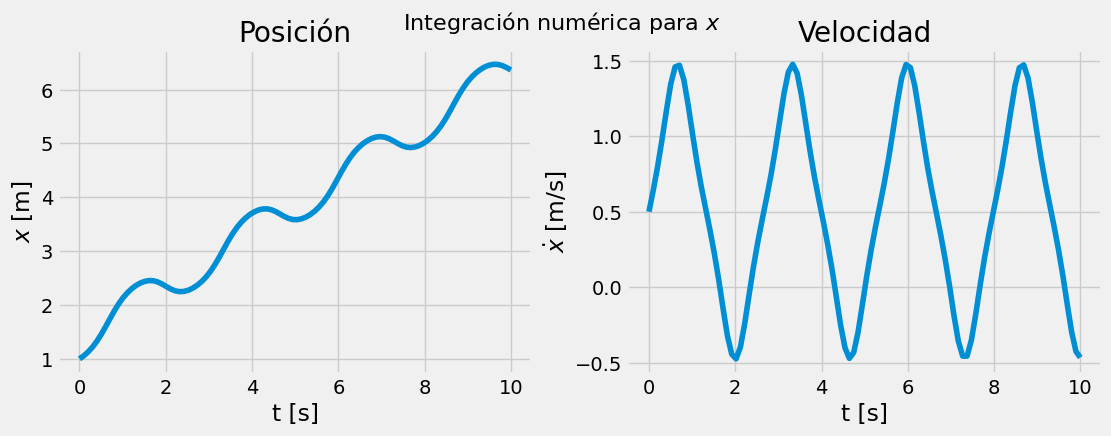

In [38]:
solucion = y_ode2
nombreCoordenada = 'x'

fig, ax = plt.subplots(nrows= 1, ncols= 2, squeeze=False, figsize=(12, 4)) # dos figuras en la misma fila
fig.suptitle('Integración numérica para $'+ nombreCoordenada + '$', fontsize=16)
ax[0,0].plot(solucion.t, solucion.y[0]) # posición x
ax[0,0].set(xlabel='t [s]', ylabel= '$' + nombreCoordenada+ '$ [m]', title='Posición')
ax[0,1].plot(solucion.t, solucion.y[1]) # velocidad x
ax[0,1].set(xlabel='t [s]', ylabel='$\dot{' + nombreCoordenada+ '}$ [m/s]', title='Velocidad')

[Text(0.5, 0, 't [s]'),
 Text(0, 0.5, '$\\dot{\\phi}$ [rad/s]'),
 Text(0.5, 1.0, 'Velocidad')]

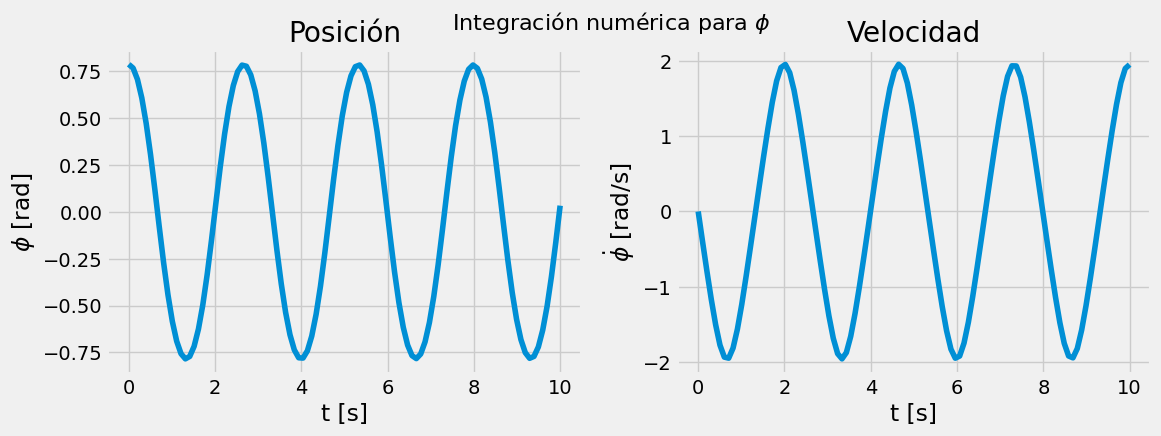

In [39]:
solucion = y_ode2
nombreCoordenada = '\phi'

fig, ax = plt.subplots(nrows= 1, ncols= 2, squeeze=False, figsize=(12, 4)) # dos figuras en la misma fila
fig.suptitle('Integración numérica para $'+ nombreCoordenada + '$', fontsize=16)
ax[0,0].plot(solucion.t, solucion.y[2]) # posición phi
ax[0,0].set(xlabel='t [s]', ylabel= '$' + nombreCoordenada+ '$ [rad]', title='Posición')
ax[0,1].plot(solucion.t, solucion.y[3]) # velocidad phi
ax[0,1].set(xlabel='t [s]', ylabel='$\dot{' + nombreCoordenada+ '}$ [rad/s]', title='Velocidad')